Trying to use [fhirtordf](https://github.com/BD2KOnFHIR/fhirtordf) for parsing the FHIR bundle from [synthea](https://synthetichealth.github.io/synthea/) to RDF, which can then be transformed to knowledge graph for use in RAG or other operations.

In [ ]:
%pip install rdflib networkx netgraph fhirtordf --user

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for dirlistproc: filename=dirlistproc-1.4.5-py3-none-any.whl size=6443 sha256=efecb1093d65452dd9cbd2938f8288817c9b0c5840fc376bce96fc87b176214c
  Stored in directory: c:\users\peter\appdata\local\pip\cache\wheels\02\5a\6f\688c77c1c42d1af11d9671e71b5cf1b4a1500551d21f4a86c5
Successfully built dirlistproc

   ------------- -------------------------- 2/6 [isodate]
  Attempting uninstall: rdflib
   ------------- -------------------------- 2/6 [isodate]
    Found existing installation: rdflib 7.2.1
   ------------- -------------------------- 2/6 [isodate]
   -------------------- ------------------- 3/6 [rdflib]
    Uninstalling rdflib-7.2.1:
   --------

In [2]:
from rdflib import Graph, URIRef, RDF, Literal, Namespace
from fhirtordf.loaders.fhirjsonloader import fhir_json_to_rdf
from fhirtordf.fhir.fhirmetavoc import FHIRMetaVoc
import networkx as nx
import json

In [36]:
g = fhir_json_to_rdf(
        json_fname='C:/Users/Peter/Documents/GitHub/daily-coding/fhir/Aaron697_Brekke496_2fa15bc7-8866-461a-9000-f739e425860a.json',
        # base_uri='https://peterdobbs77.github.io/fhir/',
        metavoc = FHIRMetaVoc(mv_file_loc="http://build.fhir.org/fhir.ttl")
    )

In [37]:
print(g.serialize(format='turtle').decode('utf-8'))

@prefix fhir: <http://hl7.org/fhir/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .

<http://hl7.org/fhir/CarePlan/af160c6b-78e8-46d9-b49f-870fafe7f27e> a fhir:CarePlan ;
    fhir:nodeRole fhir:treeRoot .

<http://hl7.org/fhir/CarePlan/af160c6b-78e8-46d9-b49f-870fafe7f27e.ttl> a owl:Ontology ;
    owl:imports fhir:fhir.ttl .

<http://hl7.org/fhir/CarePlan/bdfcbba5-ee4f-4a8f-ac12-3da0301df4ef> a fhir:CarePlan ;
    fhir:nodeRole fhir:treeRoot .

<http://hl7.org/fhir/CarePlan/bdfcbba5-ee4f-4a8f-ac12-3da0301df4ef.ttl> a owl:Ontology ;
    owl:imports fhir:fhir.ttl .

<http://hl7.org/fhir/CareTeam/82697300-ce70-49e9-9012-79a33a776b59> a fhir:CareTeam ;
    fhir:nodeRole fhir:treeRoot .

<http://hl7.org/fhir/CareTeam/82697300-ce70-49e9-9012-79a33a776b59.ttl> a owl:Ontology ;
    owl:imports fhir:fhir.ttl .

<http://hl7.org/fhir/CareTeam/a542026f-5591-4bfc-903e-6216794179ce> a fhir:CareTeam ;
    fhir:nodeRole fhir:treeRoot .

<http://hl7.org/fhir/CareTeam/a542026f-5591-4bfc-903e-62167941

In [55]:
print(len(g))

1276


Something is off in the way that the references are being created. I think `fhirtordf` is struggling to establish references based on the structure of the synthea-generated data.

Instead let's try to do the conversion manually...

In [ ]:
from rdflib import BNode

with open('../../fhir/Aaron697_Brekke496_2fa15bc7-8866-461a-9000-f739e425860a.json', 'r') as f:
    fhir_bundle = json.load(f)

manual_graph = Graph()

# limit depth on these keys
DEPTH_LIMIT_ON = ['identifier', # 'subject', 
                  'encounter', 'serviceProvider', 'individual', 'code',
                  'coding', 'valueCoding', 'type', 'text', 'verificationStatus',
                  'clinicalStatus', 'reference', 'period', 'class', 'name']
SKIP_KEYS = ['resourceType', 'id',  # because these two should already have been parsed
             'extension', 'telecom', 'address', 'maritalStatus', 'language', 'display']

# namespaces
FHIR = Namespace("http://hl7.org/fhir/")
manual_graph.bind("fhir", FHIR)
EX = Namespace("http://example.org/")
manual_graph.bind("ex", EX)

def add_resource_to_graph(resource, resource_id=None):
    if resource_id is None:
        resource_type = resource['resourceType']
        resource_id = URIRef(EX[resource_type + '/' + resource['id']])
        
        # Add basic properties for each resource
        manual_graph.add((resource_id, RDF.type, FHIR[resource_type]))
        manual_graph.add((resource_id, FHIR.nodeRole, FHIR.treeRoot))
        manual_graph.add((resource_id, FHIR.resourceType, Literal(resource_type)))
    
    # Iterate over the attributes of the resource
    for key, value in resource.items():
        if key in SKIP_KEYS:  # Skip resourceType, id, etc
            continue

        if isinstance(value, dict):  # Handle nested objects
            if key in ['subject']:
                # assuming that subject is a reference to a Patient (not necessarily true)
                entry = BNode()
                manual_graph.add((resource_id, FHIR[key], entry))
                manual_graph.add((entry, RDF.type, FHIR.Patient))
                manual_graph.add((entry, FHIR.type, FHIR.Patient))
                if 'reference' in value:
                    # reference_bundle_entry = fhir_bundle['entry'][['fullUrl'] == value['reference']]
                    # print(reference_bundle_entry)
                    # establish blank node reference
                    reference_node = BNode()
                    manual_graph.add((entry, FHIR.reference, reference_node))
                    manual_graph.add((reference_node, FHIR.value, Literal(value['reference'])))
                    # establish fhir:link
                    reference_id = str.split(value['reference'], ':')[-1] # assuming reference is of the form "urn:uuid:#######"
                    manual_graph.add((entry, FHIR.link, URIRef(EX['Patient' + '/' + reference_id])))
                if 'display' in value:
                    display_value = value['display']
                    manual_graph.add((entry, FHIR.display, Literal(display_value)))
                # print([x for x in value.items()]) # TEMP DEBUG LINE
            if key not in DEPTH_LIMIT_ON:
                add_resource_to_graph(value, resource_id)  # Recursive call for nested objects
            manual_graph.add((resource_id, FHIR[key], Literal(value)))  # Link to the nested resource
        elif isinstance(value, list):  # Handle lists
            for item in value:
                if isinstance(item, dict):  # If the item is a resource
                    if key not in DEPTH_LIMIT_ON:
                        add_resource_to_graph(item, resource_id)  # Recursive call for nested resources
                    manual_graph.add((resource_id, FHIR[key], Literal(item)))
                else:
                    manual_graph.add((resource_id, FHIR[key], Literal(item)))
        else:
            manual_graph.add((resource_id, FHIR[key], Literal(value)))

LIMIT = 6
i = 0
for entry in fhir_bundle['entry']:
    resource = entry['resource']
    add_resource_to_graph(resource, None)
    i += 1
    if i >= LIMIT:
        break

# Serialize the graph in Turtle format
print(manual_graph.serialize(format='turtle').decode('utf-8'))

{'fullUrl': 'urn:uuid:5cbc121b-cd71-4428-b8b7-31e53eba8184', 'resource': {'resourceType': 'Patient', 'id': '5cbc121b-cd71-4428-b8b7-31e53eba8184', 'text': {'status': 'generated', 'div': '<div xmlns="http://www.w3.org/1999/xhtml">Generated by <a href="https://github.com/synthetichealth/synthea">Synthea</a>.Version identifier: v2.4.0-404-ge7ce2295\n .   Person seed: 6457100290386878904  Population seed: 0</div>'}, 'extension': [{'url': 'http://hl7.org/fhir/us/core/StructureDefinition/us-core-race', 'extension': [{'url': 'ombCategory', 'valueCoding': {'system': 'urn:oid:2.16.840.1.113883.6.238', 'code': '2106-3', 'display': 'White'}}, {'url': 'text', 'valueString': 'White'}]}, {'url': 'http://hl7.org/fhir/us/core/StructureDefinition/us-core-ethnicity', 'extension': [{'url': 'ombCategory', 'valueCoding': {'system': 'urn:oid:2.16.840.1.113883.6.238', 'code': '2186-5', 'display': 'Not Hispanic or Latino'}}, {'url': 'text', 'valueString': 'Not Hispanic or Latino'}]}, {'url': 'http://hl7.org/f

In [52]:
len(manual_graph)

78

Okay, this is becoming a bit of a drag. I wonder if I can leverage the internals of `fhirtordf` better than what was resulting above with a simple run.

In [7]:
from fhirtordf.fhir.fhirmetavoc import FHIRMetaVoc
from fhirtordf.loaders.fhircollectionloader import FHIRCollection
from fhirtordf.loaders.fhirresourceloader import FHIRResource

base_uri = "http://example.org/"
target_graph = Graph()
metavoc = FHIRMetaVoc(mv_file_loc='http://build.fhir.org/fhir.ttl').g

fpath = '../../fhir/Aaron697_Brekke496_2fa15bc7-8866-461a-9000-f739e425860a.json'

fhir_collection = FHIRCollection(metavoc, fpath, base_uri, target=target_graph)

# print(fhir_collection.entries[0].graph.toPython().serialize(format='turtle').decode('utf-8'))

print(target_graph.serialize(format='turtle').decode('utf-8'))

@prefix fhir: <http://hl7.org/fhir/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .

<http://example.org/CarePlan/af160c6b-78e8-46d9-b49f-870fafe7f27e> a fhir:CarePlan ;
    fhir:nodeRole fhir:treeRoot .

<http://example.org/CarePlan/af160c6b-78e8-46d9-b49f-870fafe7f27e.ttl> a owl:Ontology ;
    owl:imports fhir:fhir.ttl .

<http://example.org/CarePlan/bdfcbba5-ee4f-4a8f-ac12-3da0301df4ef> a fhir:CarePlan ;
    fhir:nodeRole fhir:treeRoot .

<http://example.org/CarePlan/bdfcbba5-ee4f-4a8f-ac12-3da0301df4ef.ttl> a owl:Ontology ;
    owl:imports fhir:fhir.ttl .

<http://example.org/CareTeam/82697300-ce70-49e9-9012-79a33a776b59> a fhir:CareTeam ;
    fhir:nodeRole fhir:treeRoot .

<http://example.org/CareTeam/82697300-ce70-49e9-9012-79a33a776b59.ttl> a owl:Ontology ;
    owl:imports fhir:fhir.ttl .

<http://example.org/CareTeam/a542026f-5591-4bfc-903e-6216794179ce> a fhir:CareTeam ;
    fhir:nodeRole fhir:treeRoot .

<http://example.org/CareTeam/a542026f-5591-4bfc-903e-6216794179ce.ttl

## Attempting to graph result of `manaul_graph`

TODO: needs serious effort to actually understand and get to work properly

AttributeError: 'NoneType' object has no attribute 'name'

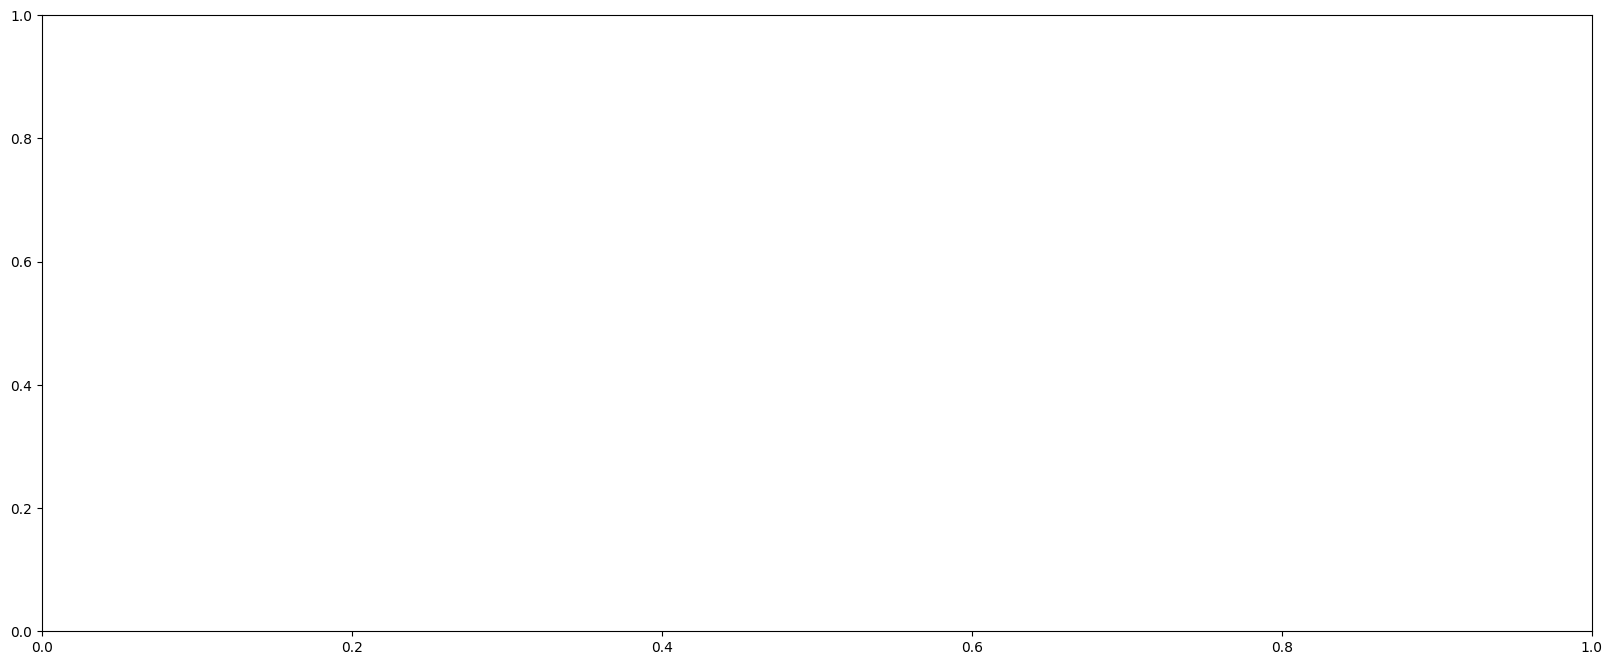

In [ ]:
from netgraph import Graph as NetGraph
import networkx as nx
# from lessons.helper import rdf_to_nx
from matplotlib import pyplot as plt

node_color= { node: "#1E1EAF" for node in manual_graph }
            # node: ('#404040' if node in G_po 
            # else '#0000FF') for node in G_prpo}

node_shapes = {}
for node in manual_graph:
    if "Patient" in node:
        node_shapes[node] = "^"
    elif "Encounter" in node:
        node_shapes[node] = "v"
    elif "DiagnosticReport" in node:
       node_shapes[node] = "s"
    else:
        node_shapes[node] = "o"

node_size = {}
for node in manual_graph:
    if "Claim" in node:
        node_size[node] = .9
    else:
        node_size[node] = 1.3
fig, ax = plt.subplots(figsize=(20,8))

manual_graph_netgraph = NetGraph(manual_graph,
          node_layout=nx.spring_layout(manual_graph, seed=1), 
          node_edge_width = 0,
          node_size = node_size,
          edge_width=.1,
          node_color = node_color,
          node_shape = node_shapes,
          arrows=False,
          ax=ax
)
plt.show()

# Start from the source

FHIR publishes a Turtle file for defining the structure of FHIR resources. Let's try that!

Build version: [http://build.fhir.org/fhir.ttl](http://build.fhir.org/fhir.ttl)

In [2]:
# 
from rdflib import Graph

fhir_kg = Graph()
fhir_kg.parse('http://build.fhir.org/fhir.ttl')
print(len(fhir_kg))

C:\Users\Peter\AppData\Roaming\Python\Python312\site-packages\rdflib\plugin.py:111: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import iter_entry_points


90061


In [3]:
print(fhir_kg.serialize(format='turtle').decode('utf-8'))

@prefix dc: <http://purl.org/dc/elements/1.1/> .
@prefix fhir: <http://hl7.org/fhir/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix w5: <http://hl7.org/fhir/w5#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

fhir:Account a owl:Class ;
    rdfs:label "Account" ;
    fhir:modifierExtensionClass fhir:_Account ;
    rdfs:comment "A financial tool for tracking value accrued for a particular purpose.  In the healthcare field, used to track charges for a patient, cost centers, etc." ;
    rdfs:subClassOf [ a owl:Restriction ;
            owl:allValuesFrom fhir:instant ;
            owl:onProperty fhir:calculatedAt ],
        [ a owl:Restriction ;
            owl:allValuesFrom fhir:AccountDiagnosisComponent ;
            owl:onProperty fhir:diagnosis ],
        [ a owl:Restriction ;
            owl:maxCardinality 1 ;
            owl:onProperty fhir:billingSta

KeyboardInterrupt: 

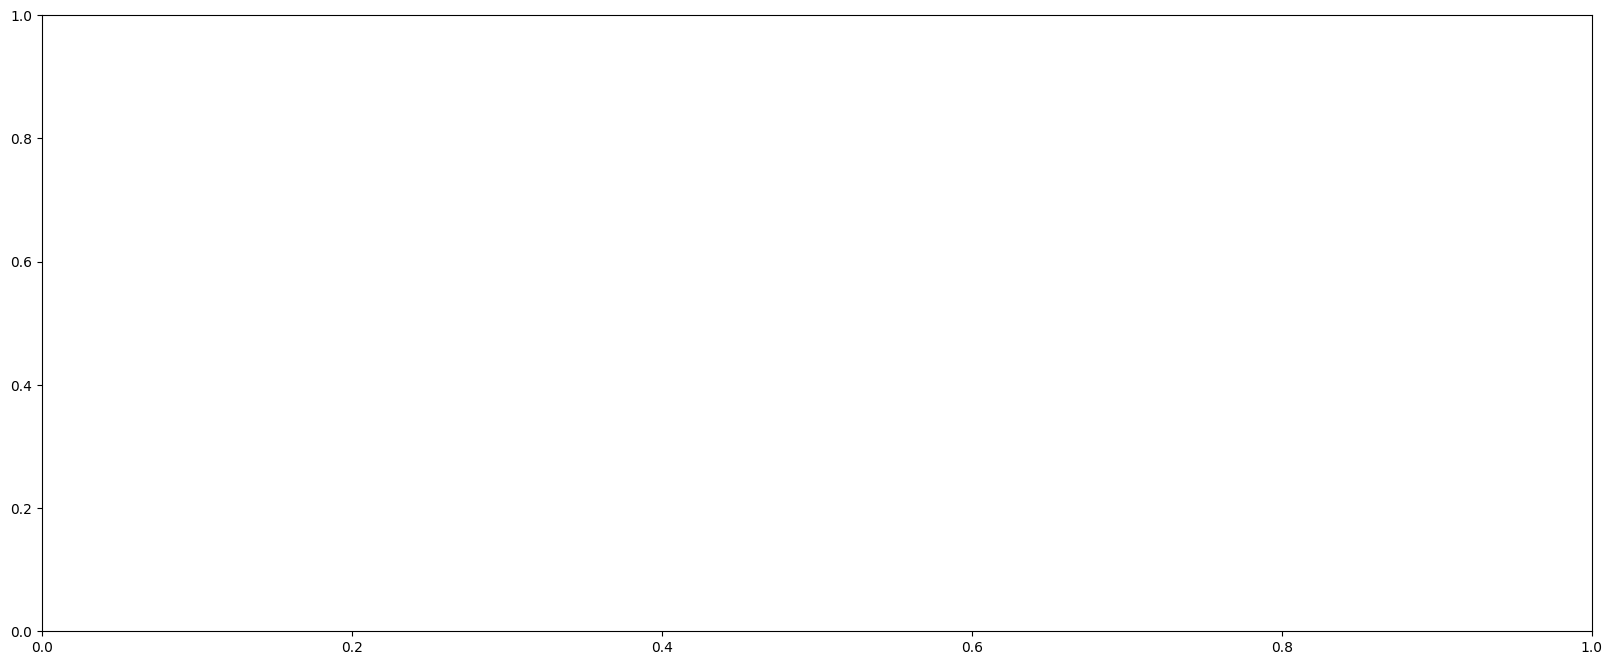

In [6]:
# Note, this cell takes a long time to run, due to the size of the knowledge graph

from netgraph import Graph as NetGraph
import networkx as nx
from matplotlib import pyplot as plt

node_color= { node: "#1E1EAF" for node in fhir_kg }
            # node: ('#404040' if node in G_po 
            # else '#0000FF') for node in G_prpo}

node_shapes = {}
for node in fhir_kg:
    if "Patient" in node:
        node_shapes[node] = "^"
    elif "Encounter" in node:
        node_shapes[node] = "v"
    elif "DiagnosticReport" in node:
       node_shapes[node] = "s"
    else:
        node_shapes[node] = "o"

node_size = {}
for node in fhir_kg:
    if "Claim" in node:
        node_size[node] = .9
    else:
        node_size[node] = 1.3
fig, ax = plt.subplots(figsize=(20,8))

fhir_kg_netgraph = NetGraph(fhir_kg,
          node_layout=nx.spring_layout(fhir_kg, seed=1), 
          node_edge_width = 0,
          node_size = node_size,
          edge_width=.1,
          node_color = node_color,
          node_shape = node_shapes,
          arrows=False,
          ax=ax
)
plt.show()

In [ ]:
patient_connections_query = """
PREFIX fhir: <http://hl7.org/fhir/>

SELECT DISTINCT ?resourceType ?encounterDetails
{
    ?resource a fhir:Resource .
    ?resource fhir:
    ?encounter fhir:subject ?patient .
    ?patient a fhir:Patient .
    ?patient fhir:name ?patientName .
}
"""